# Visualizing Yellow Taxi Trips Pickups

January 2016 Yellow Taxi Pickups

In [1]:
import pandas as pd

In [2]:
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv"

In [3]:
df = pd.read_csv(url)

In [4]:
df.shape

(10906858, 19)

In [9]:
df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount']].head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount
0,2016-01-01 00:00:00,2016-01-01 00:00:00,2,-73.990372,40.734695,-73.981842,40.732407,7.5
1,2016-01-01 00:00:00,2016-01-01 00:00:00,5,-73.980782,40.729912,-73.944473,40.716679,18.0
2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,-73.984550,40.679565,-73.950272,40.788925,33.0
3,2016-01-01 00:00:00,2016-01-01 00:00:00,1,-73.993469,40.718990,-73.962242,40.657333,16.5
4,2016-01-01 00:00:00,2016-01-01 00:00:00,3,-73.960625,40.781330,-73.977264,40.758514,8.0
5,2016-01-01 00:00:00,2016-01-01 00:18:30,2,-73.980118,40.743050,-73.913490,40.763142,19.0
6,2016-01-01 00:00:00,2016-01-01 00:26:45,2,-73.994057,40.719990,-73.966362,40.789871,26.0
7,2016-01-01 00:00:01,2016-01-01 00:11:55,1,-73.979424,40.744614,-73.992035,40.753944,9.0
8,2016-01-01 00:00:02,2016-01-01 00:11:14,1,-73.947151,40.791046,-73.920769,40.865578,18.0
9,2016-01-01 00:00:02,2016-01-01 00:11:08,1,-73.998344,40.723896,-73.995850,40.688400,11.5


In [9]:
def parseTrips(df):
    
    tripTable = pd.DataFrame()
    tripTable['start_time'] = pd.to_datetime(df['tpep_pickup_datetime'])
    tripTable['end_time'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    tripTable['passenger_count'] = df['passenger_count']
    tripTable['start_lat'] = df['pickup_latitude']
    tripTable['start_lon'] = df['pickup_longitude']
    tripTable['end_lat'] = df['dropoff_latitude']
    tripTable['end_lon'] = df['dropoff_longitude']
    tripTable['duration'] = tripTable['end_time'] - tripTable['start_time']
    tripTable['duration'] = tripTable['duration'].dt.total_seconds()
    tripTable['vehicle_type'] = "yellow"
    tripTable = tripTable[((tripTable['start_lat'] != 0) & (tripTable['end_lat'] != 0))]
    
    tripTable = tripTable.sort_values(by=['start_time', 'end_time'])
    return tripTable

In [10]:
tripTable = parseTrips(df)

In [11]:
tripTable.head()

,start_time,end_time,passenger_count,start_lat,start_lon,end_lat,end_lon,duration,vehicle_type
0,2016-01-01,2016-01-01,2,40.734695,-73.990372,40.732407,-73.981842,0.0,yellow
1,2016-01-01,2016-01-01,5,40.729912,-73.980782,40.716679,-73.944473,0.0,yellow
2,2016-01-01,2016-01-01,1,40.679565,-73.984550,40.788925,-73.950272,0.0,yellow
3,2016-01-01,2016-01-01,1,40.718990,-73.993469,40.657333,-73.962242,0.0,yellow
4,2016-01-01,2016-01-01,3,40.781330,-73.960625,40.758514,-73.977264,0.0,yellow


In [12]:
tripTable.tail()

,start_time,end_time,passenger_count,start_lat,start_lon,end_lat,end_lon,duration,vehicle_type
8042549,2016-01-31 23:59:58,2016-02-01 00:07:36,1,40.754173,-73.984741,40.780537,-73.983727,458.0,yellow
8042551,2016-01-31 23:59:59,2016-02-01 00:07:26,2,40.734329,-74.002945,40.739185,-73.996948,447.0,yellow
8042552,2016-01-31 23:59:59,2016-02-01 00:09:28,1,40.728230,-73.999115,40.738449,-73.997169,569.0,yellow
8042553,2016-01-31 23:59:59,2016-02-01 00:12:16,1,40.720074,-73.988335,40.743851,-74.006645,737.0,yellow
8042058,2016-01-31 23:59:59,2016-02-01 00:13:01,1,40.722889,-73.988907,40.689171,-73.960037,782.0,yellow


# Visualizing with Datashader

In [13]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()

Loading BokehJS ...

In [14]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno

In [15]:
def clipDataToBoundingBox(df, bbox):
    min_lon, min_lat, max_lon, max_lat = bbox
    clipped = df[((df['start_lat'] >= min_lat) & (df['start_lat'] <= max_lat) &\
                  (df['start_lon'] >= min_lon) & (df['start_lon'] <= max_lon) &\
                  (df['end_lat'] >= min_lat)   & (df['end_lat']   <= max_lat) &\
                  (df['end_lon'] >= min_lon)   & (df['end_lon']   <= max_lon))]
    return clipped

In [16]:
nyc_bbox = [-74.278564,40.485604,-73.609772,40.945676]
tripTable_clipped = clipDataToBoundingBox(tripTable, nyc_bbox)

In [17]:
background = "black"
export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))

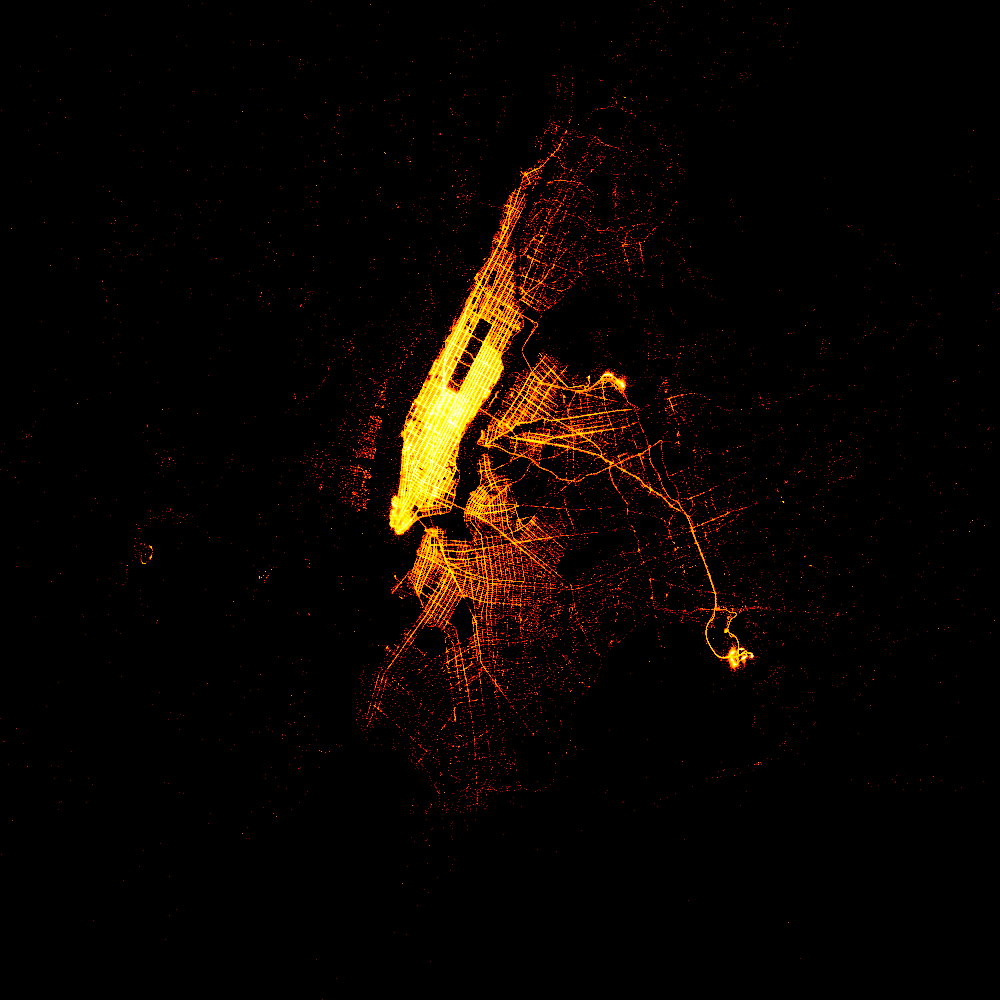

In [18]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(tripTable_clipped, 'start_lon', 'start_lat')
export(tf.shade(agg, cmap = cm(Hot,0.2), how='eq_hist'),"passenger_count")

# Zoom into LaGuardia Airport

In [38]:
lga_bbox = [-73.893785,40.758245,-73.859269,40.782900]
lga_pickups = clipDataToBoundingBox(tripTable, lga_bbox)

In [47]:
tf.shade?

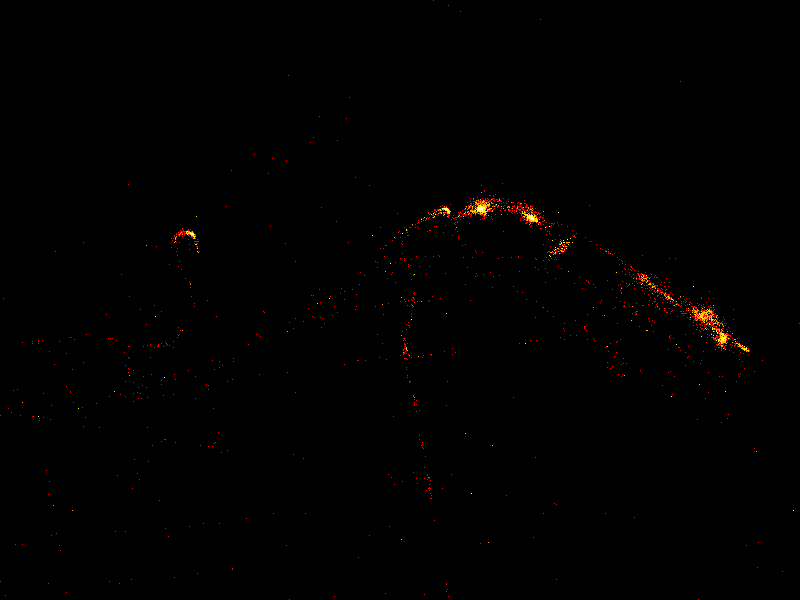

In [50]:
cvs = ds.Canvas(plot_width=800, plot_height=600)
agg = cvs.points(lga_pickups, 'start_lon', 'start_lat')
export(tf.shade(agg, cmap = cm(Hot,0.3), how='eq_hist'),"passenger_count")

# February 2016 Yellow Taxi Trips

In [53]:
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-02.csv"

In [54]:
df = pd.read_csv(url)

In [55]:
df.shape

(11382049, 19)

In [56]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-02-25 17:24:20,2016-02-25 17:27:20,2,0.70,-73.947250,40.763771,1,N,-73.992012,40.735390,2,5.0,0.0,0.5,0.0,0.0,0.3,5.8
1,2,2016-02-25 23:10:50,2016-02-25 23:31:50,2,5.52,-73.983017,40.750992,1,N,-73.988586,40.758839,2,20.0,0.5,0.5,0.0,0.0,0.3,21.3
2,2,2016-02-01 00:00:01,2016-02-01 00:10:52,6,1.99,-73.992340,40.758202,1,N,-73.964355,40.757977,1,9.5,0.5,0.5,0.7,0.0,0.3,11.5
3,1,2016-02-01 00:00:04,2016-02-01 00:05:16,1,1.50,-73.981453,40.749722,1,N,-73.982323,40.763985,2,6.5,0.5,0.5,0.0,0.0,0.3,7.8
4,2,2016-02-01 00:00:05,2016-02-01 00:20:59,1,5.60,-74.000603,40.729755,1,N,-73.951324,40.669834,1,20.0,0.5,0.5,4.0,0.0,0.3,25.3


In [57]:
tripTable = parseTrips(df)

In [58]:
tripTable.head()

,start_time,end_time,passenger_count,start_lat,start_lon,end_lat,end_lon,duration,vehicle_type
57,2016-02-01 00:00:00,2016-02-01 00:06:47,1,40.728554,-73.981636,40.739548,-73.980484,407.0,yellow
59,2016-02-01 00:00:01,2016-02-01 00:03:16,3,40.662441,-73.949776,40.662582,-73.948250,195.0,yellow
2,2016-02-01 00:00:01,2016-02-01 00:10:52,6,40.758202,-73.992340,40.757977,-73.964355,651.0,yellow
61,2016-02-01 00:00:03,2016-02-01 00:03:59,1,40.747387,-73.976952,40.744812,-73.986938,236.0,yellow
60,2016-02-01 00:00:03,2016-02-01 00:05:38,1,40.754765,-73.968605,40.762531,-73.977112,335.0,yellow


In [59]:
nyc_bbox = [-74.278564,40.485604,-73.609772,40.945676]
tripTable_clipped = clipDataToBoundingBox(tripTable, nyc_bbox)

In [60]:
background = "black"
export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))

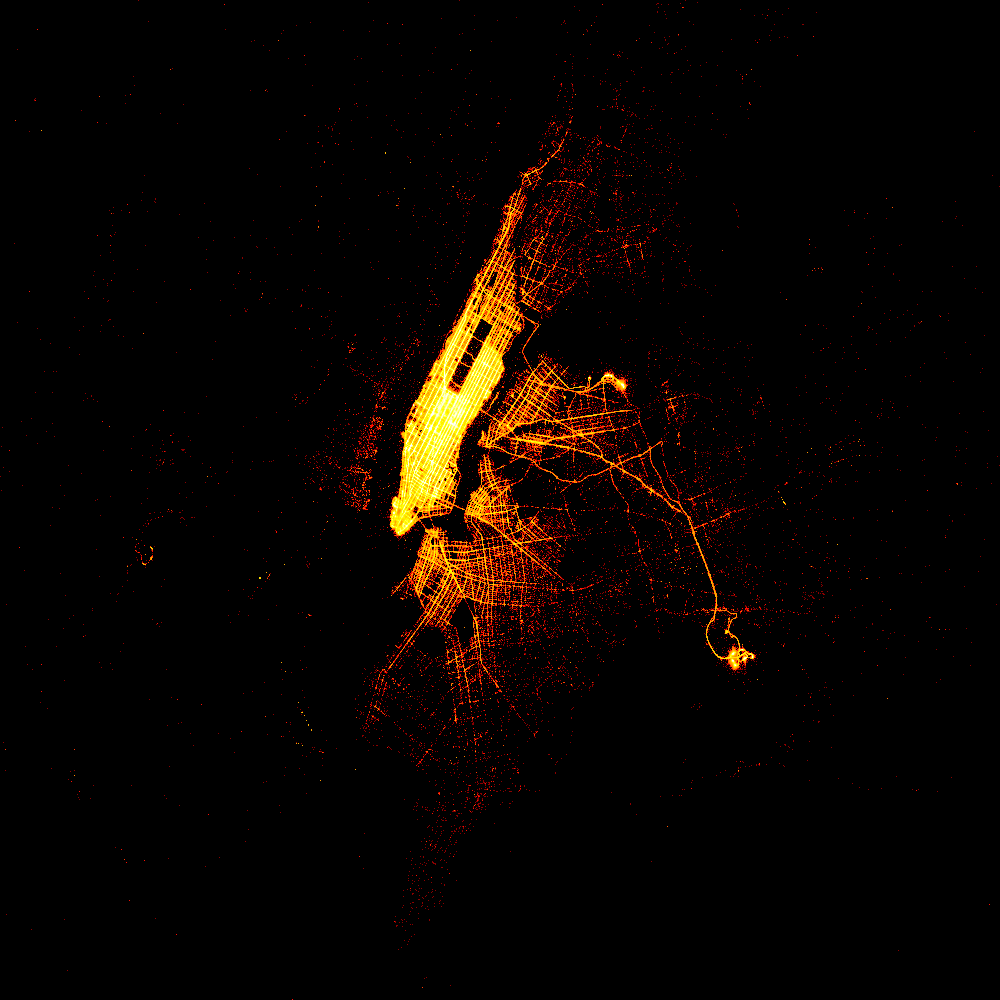

In [61]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(tripTable_clipped, 'start_lon', 'start_lat')
export(tf.shade(agg, cmap = cm(Hot,0.2), how='eq_hist'),"passenger_count")

# March 2016 Yellow Taxi Trips

In [62]:
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-03.csv"

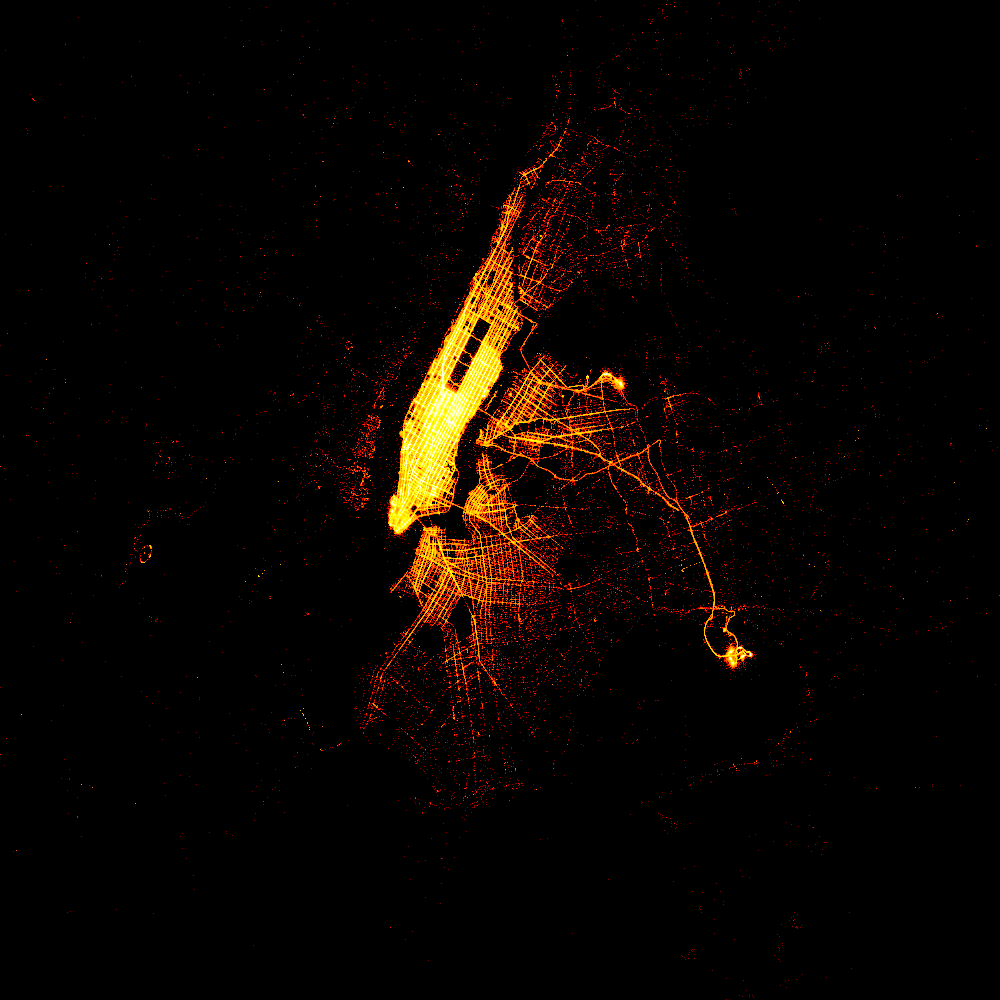

In [63]:
df = pd.read_csv(url)
tripTable = parseTrips(df)

nyc_bbox = [-74.278564,40.485604,-73.609772,40.945676]
tripTable_clipped = clipDataToBoundingBox(tripTable, nyc_bbox)

background = "black"
export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))

cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(tripTable_clipped, 'start_lon', 'start_lat')
export(tf.shade(agg, cmap = cm(Hot,0.2), how='eq_hist'),"passenger_count")

# April 2016 Yellow Taxi Trips

In [64]:
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-04.csv"

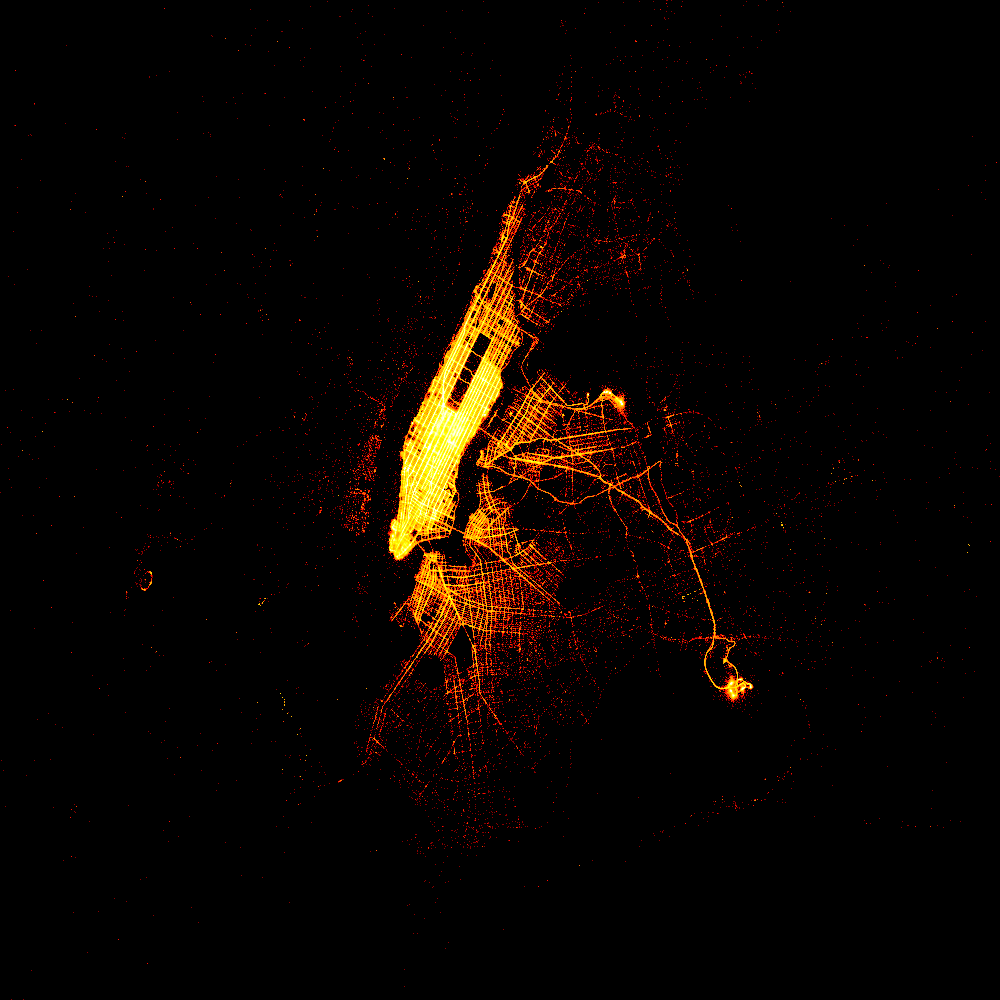

In [65]:
df = pd.read_csv(url)
tripTable = parseTrips(df)

nyc_bbox = [-74.278564,40.485604,-73.609772,40.945676]
tripTable_clipped = clipDataToBoundingBox(tripTable, nyc_bbox)

background = "black"
export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))

cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(tripTable_clipped, 'start_lon', 'start_lat')
export(tf.shade(agg, cmap = cm(Hot,0.2), how='eq_hist'),"passenger_count")

# May 2016 Yellow Taxi Trips

In [67]:
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv"

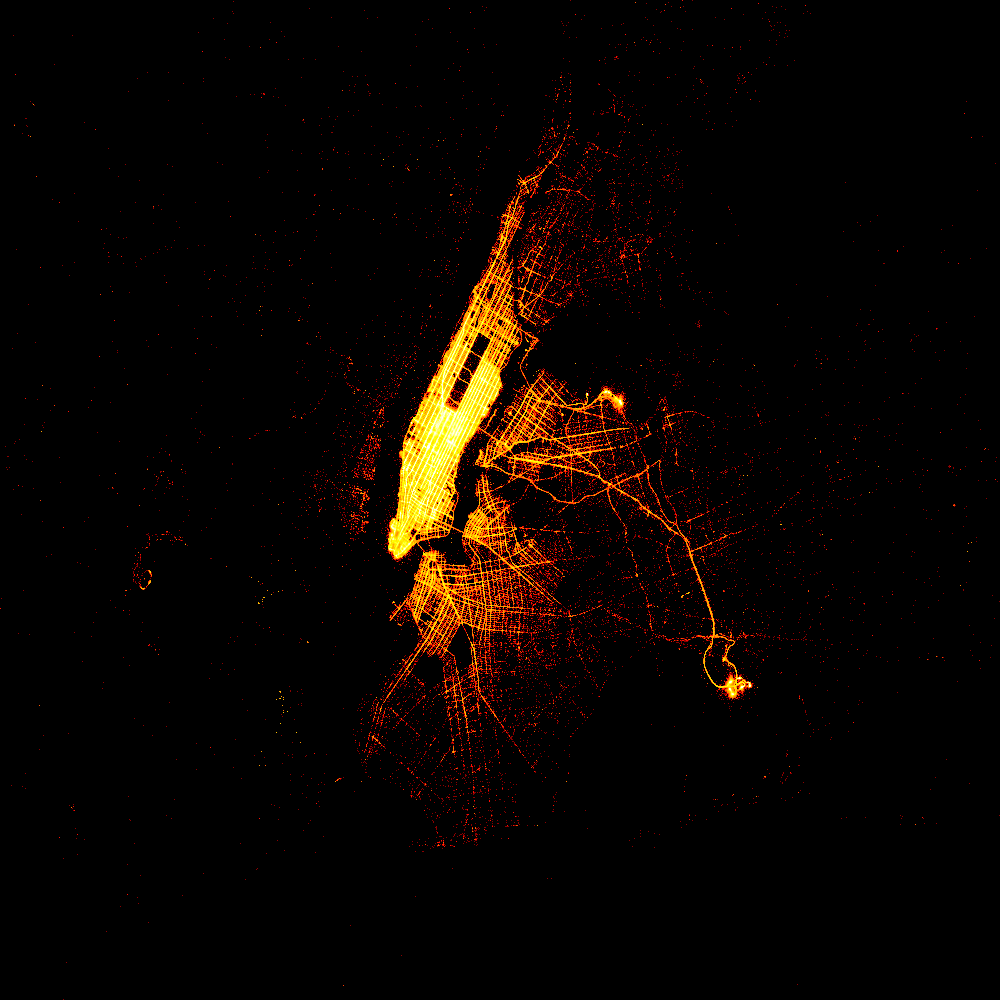

In [68]:
df = pd.read_csv(url)
tripTable = parseTrips(df)

nyc_bbox = [-74.278564,40.485604,-73.609772,40.945676]
tripTable_clipped = clipDataToBoundingBox(tripTable, nyc_bbox)

background = "black"
export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))

cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(tripTable_clipped, 'start_lon', 'start_lat')
export(tf.shade(agg, cmap = cm(Hot,0.2), how='eq_hist'),"passenger_count")